In [1]:
# random forest

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import re
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import random

In [3]:
os.getcwd()
# from thon.Choose import choose_features
from thon.churn import rollover, save_model, tree_importance, plot_eval, bake_pred
#data = choose_features("data/out/features.csv", cv_range = (0, 30), save = False)

In [4]:
data = pd.read_csv("data/out/features.csv")
random.seed(0)

In [5]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, shuffle = False)

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state = 0))
])

In [7]:
search = GridSearchCV(pipeline,
                      {'model__n_estimators':np.arange(50, 301, 50)},                      
                      cv = 5,
                      scoring = 'neg_mean_squared_error',
                      verbose = 1)

In [8]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'model__n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='neg_mean_squared_error', verbose=1)

In [9]:
search.best_params_.get("model__n_estimators")

50

In [20]:
# Training data

# Train the model
randomforestmodel = RandomForestRegressor(n_estimators = search.best_params_.get("model__n_estimators"), random_state = 0, max_features = "sqrt")
randomforestmodel.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(randomforestmodel.predict(X_train), index=X_train.index)
test_pred = pd.Series(randomforestmodel.predict(X_test), index=X_test.index)

In [21]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

158.6535999999999


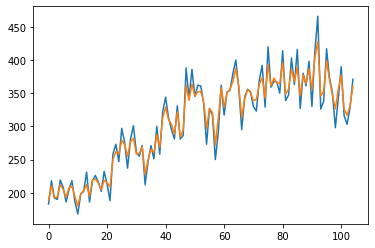

In [22]:
plot_eval(train_pred, y_train)

7801.406657777777


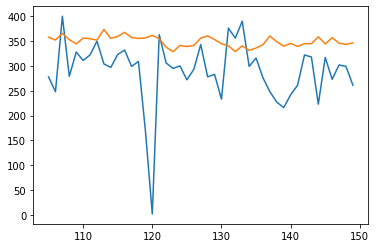

In [23]:
plot_eval(test_pred, y_test)

In [24]:
# feature names used in model
imp = tree_importance(randomforestmodel, X_train.columns, save = False)
imp.sort_values("importance", ascending = False)

,importance
unemp_lag12,0.085337
month,0.063869
hcpi_lag3,0.061886
manufinv_lag12,0.061846
ltrucksa_lag3,0.058551
...,...
g_used_cars_lag3,0.001256
discount_lag3,0.001250
bin,0.001115
prodmanuf_lag9,0.000848


In [25]:
hasattr(randomforestmodel, "feature_importances_")

True

In [26]:
save_model(randomforestmodel, "randomforestmodel.pkl")

In [27]:
newdata = rollover(imp)
newdata

ValueError: Unable to parse string "m_num" at position 0

,month,10yinf_lag9,altsales_lag3,durable_lag9,g_car_lag3,g_new_cars_lag3,g_tips_for_buying_a_car_lag9,g_used_cars_lag3,kwhcost_lag3,localrent_lag3,...,oil_lag9,sahmrule_lag9,sentiment_lag3,TM_lag12,TM_v_lag3,tmaturity_lag12,totalsa_lag3,unemployment_lag12,XOM_lag12,XOM_v_lag6
0,154,2.45,13.319,264356,96,65,18,54,0.118,432.474,...,85.622381,-0.20,51.5,176.57,3926911,1.19,13.811,4.6,64.47,505298620
1,155,2.46,13.185,262494,93,67,32,55,0.118,435.210,...,94.267000,-0.13,58.2,177.85,4927748,1.05,13.690,4.2,59.84,659735850
2,156,2.85,13.582,264258,82,63,17,49,0.118,439.701,...,112.440000,-0.10,58.6,185.30,5817079,0.78,14.057,3.9,61.19,660321520


In [19]:
np.where(np.isnan(newdata))

(array([], dtype=int64), array([], dtype=int64))

In [20]:
newdata.iloc[:,15]
newdata.columns[15]

'ngf_lag12'

In [21]:
# predict
pred = randomforestmodel.predict(newdata)
pred

array([316.3       , 309.68      , 329.42666667])

In [22]:
[349.28, 353.76, 343.72]

[349.28, 353.76, 343.72]

In [23]:
full = bake_pred(y_train, y_test, pred)

In [24]:
full.to_csv("data/out/random.csv")

In [25]:
full

,n,group
0,153.000000,train
1,169.000000,train
2,184.000000,train
3,183.000000,train
4,218.000000,train
...,...,...
151,299.000000,test
152,261.000000,test
153,316.300000,pred
154,309.680000,pred
